# MIT Indoor Scenes Recognition

Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.

MIT has provided a dataset consisting of 67 Indoor categories, and a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. The dataset can be accessed at https://web.mit.edu/torralba/www/indoor.html

The data can be downloaded from the website mentioned above. The size is 2.4GB. This notebook starts with data present in home folder. After downloading data from the tar link, there should be a folder called Images. This is what we will be using as the dataset.

<img src="mit.png" width=1280 >

In [2]:
# Usual Imports
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt


# Pytorch Image Imports
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

# Neural Network Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import models
from torch.optim import lr_scheduler

# Image Processing Imports
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid

C:\Users\tejas\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

The data contains images and their annotations within a list. The text file 'TrainImages.txt' contains annotations to the images used in the training set, while the 'TestImages.txt' contains the same for the testing set. The Images folder contains subfolders that correspond to the classes. There are 67 image classes. The first step is to get the information about images into variables that can be used during the model training. Furthermore, we can split the training set into the training and validation sets.

In [3]:
# Image Classes
classes = os.listdir('Images')
print('Classes:',classes,'\n')
print('Number of classes:',len(classes))

Classes: ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar'] 

Number of classes: 67


In [4]:
labels2keys = {value: key for (key,value) in enumerate(classes)}
keys2labels = {key: value for (key,value) in enumerate(classes)}

We can now get image file paths in a list using these classes.

In [5]:
# Get image file paths
root_dir = 'Images'
img_paths = []
for img_class in classes:
    img_dir = os.path.join(root_dir,img_class)
    img_paths.extend([os.path.join(img_dir,f) for f in os.listdir(img_dir)])
print(len(img_paths))

15620


In [6]:
# Check all images are valid
valid_img_paths = [i for i in img_paths if cv2.imread(i) is not None]
print(len(valid_img_paths))

15590


Thus, it seems that there are a few corrputed image files. In total, we have 15590 images. Next, we can write a simple function to get class of an image using its path, and use it to get the labels of images in a variable.

In [7]:
def get_labels(img_paths):
    labels = []
    for i in img_paths:
        labels.append(i.split('\\')[-2])
    return labels
        
labels = get_labels(valid_img_paths)
print(len(labels))
numeric_labels = [labels2keys[label] for label in labels]

15590


In order to reduce overfitting of our Convolutional Neural Network (CNN), we can augment the images in different ways. This helps the network to learn general features and be robust. Albumentations (https://albumentations.ai/) is a great library for this purpose. 

First we create Albumentations Dataset class

In [8]:
class AlbumentationsDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

Next, we create an image augmentation pipeline by creating a Compose class instance. As an argument to the Compose class, we need to pass a list of augmentations we want to apply. A call to Compose will return a transform function that will perform image augmentation.

In [9]:
alb_transform = A.Compose([
    # Resize the image to 256*256
    A.Resize(256, 256),
    # Select a random crop of size width*height
    A.RandomCrop(width=224, height=224),
    # Flip the image horizontally with probability p
    A.HorizontalFlip(p=0.5),
    # Change brightness and contrast of image with probability p
    A.RandomBrightnessContrast(p=0.2),
    # Convert to torch tensor
    ToTensorV2()
])

Finally, we can create an Albumentations Dataset using all the image paths, labels and our albumentation transform class.

In [10]:
dataset = AlbumentationsDataset(file_paths=valid_img_paths, labels=numeric_labels, transform=alb_transform)
dataset

Now, we can load this data into a DataLoader. It takes a data set and returns batches of images and corresponding labels. Before we do so, we should split the dataset into 3 parts: train, val, test.

In [11]:
train_ds, val_ds, test_ds = random_split(dataset, [13000, 2000, 590])
print('Train:',len(train_ds), 'Val:', len(val_ds), 'Test:', len(test_ds))

Train: 13000 Val: 2000 Test: 590


In [12]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=0)

We can create a helper function to visualize an image or a single batch of images.

In [13]:
def show_images(images, labels, nmax=64):
    fig = plt.figure()
    fig.set_size_inches(20, 12)
    grid = ImageGrid(fig, 111, nrows_ncols=(6,12), axes_pad=(0.1,0.3), share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im, lb in zip(grid, images, labels):
        # Iterating over the grid returns the Axes.
        ax.imshow(im.permute(1,2,0))
        ax.set_title(lb)
    plt.show()

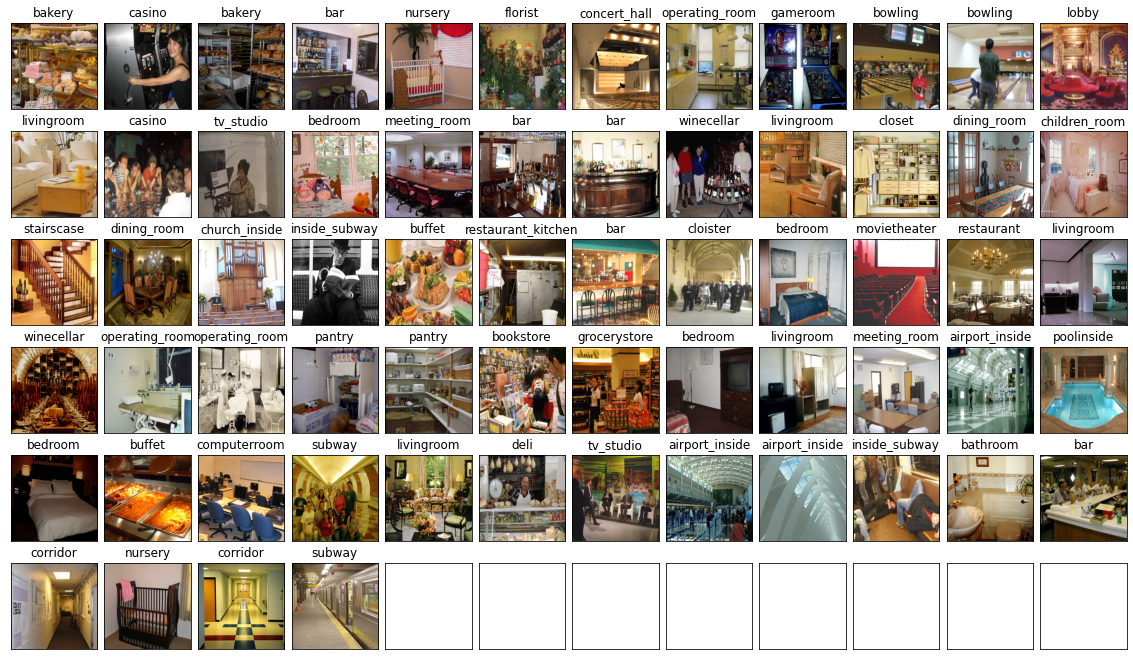

In [14]:
images, labels = next(iter(train_dl))
show_images(images, [keys2labels[label] for label in labels.tolist()])

## Building CNN

Before training, we must send the neural network onto GPU

In [28]:
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

NameError: name 'device' is not defined

Now that we have the dataloaders, we can design a CNN. We follow the general architecture of AlexNet.

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2)
        
        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128*6*6, 1024, bias=True)
        self.fc2 = nn.Linear(1024, len(classes), bias=True)
        
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)

In [43]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
         MaxPool2d-2         [-1, 32, 111, 111]               0
            Conv2d-3         [-1, 64, 109, 109]          18,496
         MaxPool2d-4           [-1, 64, 54, 54]               0
            Conv2d-5          [-1, 128, 26, 26]          73,856
         MaxPool2d-6          [-1, 128, 13, 13]               0
            Conv2d-7            [-1, 128, 6, 6]         147,584
            Linear-8                 [-1, 1024]       4,719,616
           Dropout-9                 [-1, 1024]               0
           Linear-10                   [-1, 67]          68,675
Total params: 5,029,123
Trainable params: 5,029,123
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 23.14
Params size (MB): 19.18
Estim

We define the loss function and the optimizer

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
learning_rate_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

## Training and Validating

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=100):
    min_val_loss = np.inf
    for epoch in range(num_epochs):

        train_loss = 0.0
        model.train()
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss = loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1} \t\t \
                Training Loss: {train_loss / len(train_dl)} \t\t \
                Validation Loss: {val_loss / len(val_dl)}')
        if min_val_loss > val_loss:
            print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
            min_val_loss = val_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'customCNN.pth')

    print('Finished Training')
    
    return model

In [46]:
model = train_model(model, criterion, optimizer, learning_rate_scheduler, num_epochs=50)

Epoch 1 		                 Training Loss: 3.906445753340628 		                 Validation Loss: 1.738423466682434
Validation Loss Decreased(inf--->55.629551) 	 Saving The Model
Epoch 2 		                 Training Loss: 3.6160345650186727 		                 Validation Loss: 1.7657634019851685
Epoch 3 		                 Training Loss: 3.426469992188846 		                 Validation Loss: 1.637103796005249
Validation Loss Decreased(55.629551--->52.387321) 	 Saving The Model
Epoch 4 		                 Training Loss: 3.270317129060334 		                 Validation Loss: 1.4803214073181152
Validation Loss Decreased(52.387321--->47.370285) 	 Saving The Model
Epoch 5 		                 Training Loss: 3.1387272418714036 		                 Validation Loss: 1.186964750289917
Validation Loss Decreased(47.370285--->37.982872) 	 Saving The Model
Epoch 6 		                 Training Loss: 3.032270378926221 		                 Validation Loss: 1.4819175004959106
Epoch 7 		                 Training Loss:

In [47]:
model.load_state_dict(torch.load('customCNN.pth'))

<All keys matched successfully>

## Model Accuracy

Now that we have our model, we can test its performance on the test dataset

In [49]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 590 test images: {100 * correct // total} %')

Accuracy of the network on the 590 test images: 32 %


We get an accuracy of 32%. Note that this was a rudimentary model with randomly set convolutional neural nets. The probability of randomly guessing one of the 67 categories is (1/67)*100 = 1.5%. Thus, our model did learn to recognize some of the features. We can have a look at the type of predictions made by the model in a batch of the test dataset.

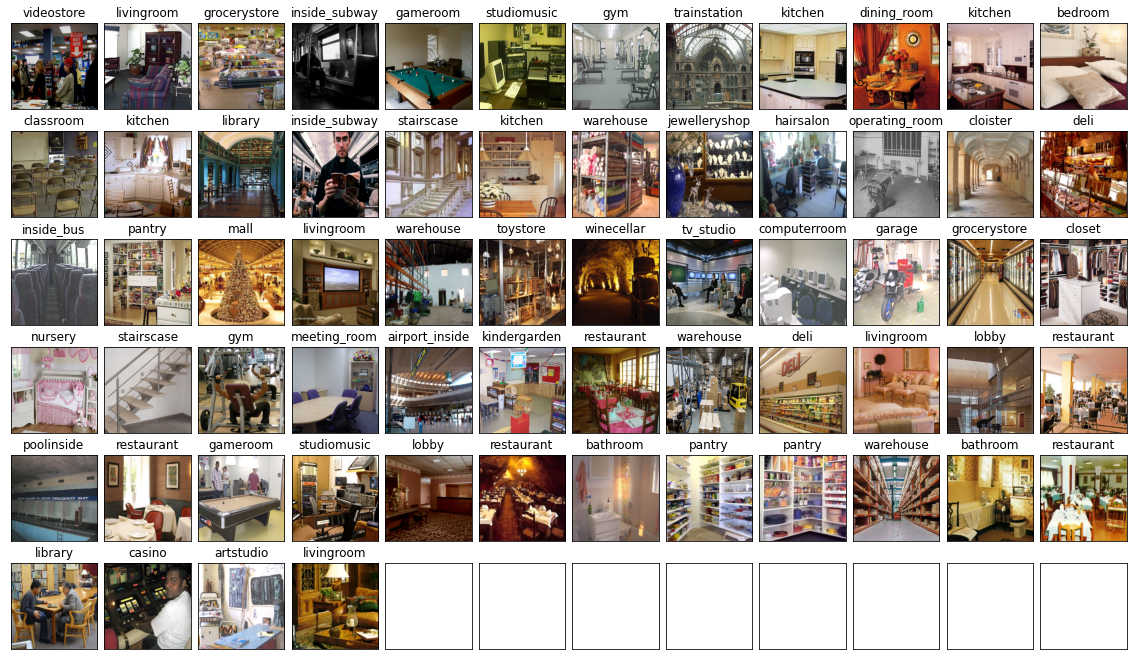

In [50]:
dataiter = iter(test_dl)
images, labels = dataiter.next()
show_images(images, [keys2labels[label] for label in labels.tolist()])

In [52]:
images, labels = images.to(device), labels.to(device)
outputs = model(images.float())
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu()
images = images.cpu()

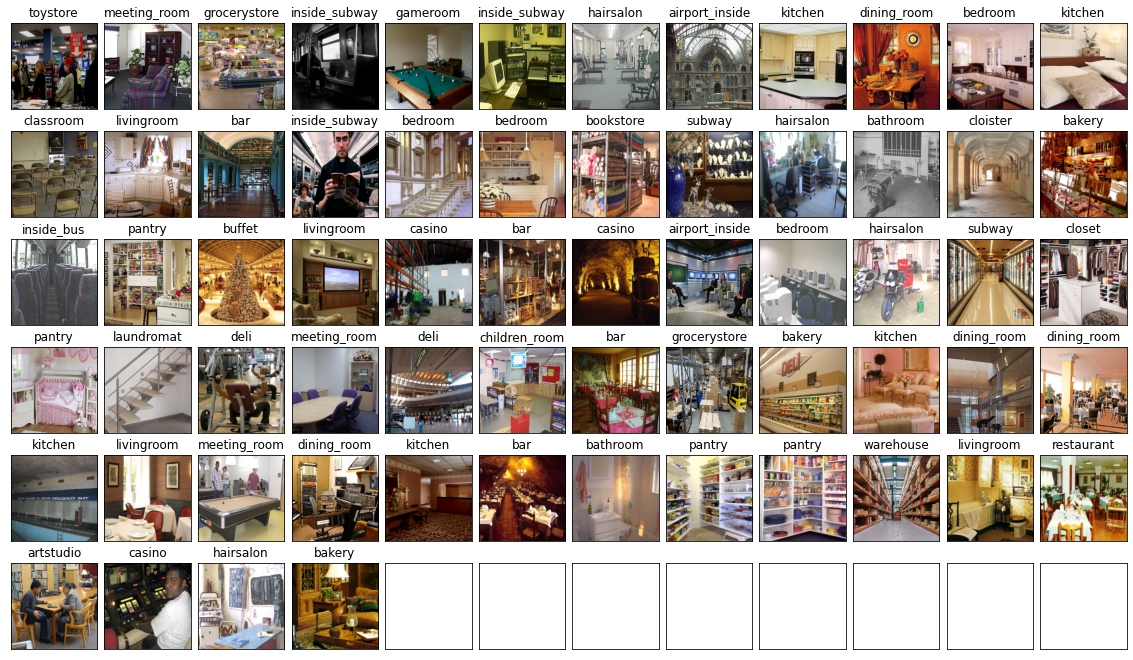

In [53]:
show_images(images, [keys2labels[label] for label in predicted.tolist()])

## Transfer Learning

We have built our own CNN, but it has a low accuracy. It would take many iterations before we can figure out the best parameters for the network in order to get a high enough accuracy. To save time in this process, we can turn to Transfer Learning. Since image classification is a much-reseearched topic, there are many pre-trained CNNs out there that have been trained on millions of datapoints. We can use one such pre-trained model and fit it to our case.

In [54]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This is the ResNet50 CNN. We can change the fc layer of the model to fit our final number of categories.

In [55]:
# Avoid backpropagation of pretrained layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,len(classes))
)

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
model.to(device)
learning_rate_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

Now we can train our model again.

In [57]:
model = train_model(model, criterion, optimizer, learning_rate_scheduler, num_epochs=50)

Epoch 1 		                 Training Loss: 2.4673554312949086 		                 Validation Loss: 1.0244280099868774
Validation Loss Decreased(inf--->32.781696) 	 Saving The Model
Epoch 2 		                 Training Loss: 1.5873837774875117 		                 Validation Loss: 0.6830923557281494
Validation Loss Decreased(32.781696--->21.858955) 	 Saving The Model
Epoch 3 		                 Training Loss: 1.3375624879902483 		                 Validation Loss: 0.6226857900619507
Validation Loss Decreased(21.858955--->19.925945) 	 Saving The Model
Epoch 4 		                 Training Loss: 1.213634199371525 		                 Validation Loss: 1.0909942388534546
Epoch 5 		                 Training Loss: 1.1266174842329586 		                 Validation Loss: 0.6507490873336792
Epoch 6 		                 Training Loss: 1.0893575230649872 		                 Validation Loss: 0.4491163492202759
Validation Loss Decreased(19.925945--->14.371723) 	 Saving The Model
Epoch 7 		                 Training

In [58]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 590 test images: {100 * correct // total} %')

Accuracy of the network on the 590 test images: 64 %


Thus, we get an accuracy of 64% using the ResNet architecture. We can probably try to improve the performance by playing with the hyperparameters of the network. However, considering that many research-level models achieve an accuracy of around 80%, we can conclude that our model is pretty good for a rudimentary construction of a CNN.